# 03 - ECT Clinical analysis

This notebook investigates relationships between changes in spectral features of scalp EEG and clinical severity ratings for patients undergoing ECT for treatment resistant depression. 

Symptom severity is assesssed with the HAMD-17 rating scale.

## imports

In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from pingouin import corr, ttest

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [2]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [3]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

In [4]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [5]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [6]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [7]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_18620/335215666.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [8]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [9]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [10]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [11]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_cf,diff_theta_bw,diff_theta_amp,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,0.498191,-1.131251,-0.374163,-1.047483,0.081001,-1.181671,0.275602,-0.286402,-1.257006,-0.921488
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.728374,-0.244217,0.017846,0.160953,0.813720,0.140621,0.476360,0.772309,0.295766,-0.165961
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,0.864910,-0.363973,-0.702215,-1.067190,1.695906,-1.102768,-0.338883,-0.726749,-0.580045,-0.353966
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.287061,-0.086379,-0.047091,-0.212238,0.028742,-0.080232,0.100156,-0.051523,-0.172336,-0.081453
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,0.826101,-1.042193,-0.631210,-1.106876,1.022782,-2.992160,0.124481,-0.211126,-0.712337,-0.495305
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,NaN,NaN,NaN,-0.899623,0.645290,-2.516315,-0.351969,-0.668322,-0.656820,-0.451485
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.479380,-0.338807,-0.183102,-0.507658,1.255797,-0.260381,0.767590,0.051426,-0.437258,-0.056655
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,0.733550,-1.948405,-0.409081,-1.560811,1.123630,-4.015184,-0.028929,-1.114945,-1.451715,-0.655069
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.199892,-2.464727,-0.686755,-1.644640,1.133505,-3.151910,-0.462284,-1.134528,-1.109276,-0.431640
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,0.692422,0.470979,-0.374228,-0.846204,0.572586,-1.320593,0.738248,0.159967,-1.013398,-0.760363


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [12]:
ECT_clinical = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_clinical.csv')
ECT_HAMD = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col=0)

# rename columns

ECT_HAMD = ECT_HAMD[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalPre': 'pre_HAMD',
                                                                                 'TotalPost': 'post_HAMD'})
ECT_clinical = ECT_clinical[['subject', 'x_OfTxsReceived']].copy().rename(columns={'subject': 'patient',
                                                                                   'x_OfTxsReceived': 'n_TxsReceived'})

# merge into single dataframe
all_clinical = pd.merge(ECT_HAMD, ECT_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [13]:
clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

In [14]:
clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,pre_HAMD,post_HAMD,n_TxsReceived
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-1.047483,0.081001,-1.181671,0.275602,-0.286402,-1.257006,-0.921488,33.0,7.0,8.0
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.160953,0.813720,0.140621,0.476360,0.772309,0.295766,-0.165961,24.0,13.0,10.0
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-1.067190,1.695906,-1.102768,-0.338883,-0.726749,-0.580045,-0.353966,21.0,20.0,11.0
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.212238,0.028742,-0.080232,0.100156,-0.051523,-0.172336,-0.081453,25.0,22.0,15.0
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-1.106876,1.022782,-2.992160,0.124481,-0.211126,-0.712337,-0.495305,24.0,NaN,14.0
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.899623,0.645290,-2.516315,-0.351969,-0.668322,-0.656820,-0.451485,23.0,30.0,17.0
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.507658,1.255797,-0.260381,0.767590,0.051426,-0.437258,-0.056655,34.0,12.0,11.0
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-1.560811,1.123630,-4.015184,-0.028929,-1.114945,-1.451715,-0.655069,NaN,NaN,NaN
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.644640,1.133505,-3.151910,-0.462284,-1.134528,-1.109276,-0.431640,NaN,NaN,NaN
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,-0.846204,0.572586,-1.320593,0.738248,0.159967,-1.013398,-0.760363,23.0,9.0,17.0


In [15]:
clin_eeg_df.columns

Index(['patient', 'pre_delta_cf', 'pre_delta_bw', 'pre_delta_amp',
       'pre_delta_bp', 'pre_theta_cf', 'pre_theta_bw', 'pre_theta_amp',
       'pre_theta_bp', 'pre_alpha_cf', 'pre_alpha_bw', 'pre_alpha_amp',
       'pre_alpha_bp', 'pre_offset', 'pre_exponent', 'pre_theta_present',
       'pre_ch_theta_perc', 'pre_delta_present', 'pre_ch_delta_perc',
       'pre_alpha_present', 'pre_ch_alpha_perc', 'post_delta_cf',
       'post_delta_bw', 'post_delta_amp', 'post_delta_bp', 'post_theta_cf',
       'post_theta_bw', 'post_theta_amp', 'post_theta_bp', 'post_alpha_cf',
       'post_alpha_bw', 'post_alpha_amp', 'post_alpha_bp', 'post_offset',
       'post_exponent', 'post_theta_present', 'post_ch_theta_perc',
       'post_delta_present', 'post_ch_delta_perc', 'post_alpha_present',
       'post_ch_alpha_perc', 'diff_delta_cf', 'diff_delta_bw',
       'diff_delta_amp', 'diff_delta_bp', 'diff_theta_cf', 'diff_theta_bw',
       'diff_theta_amp', 'diff_theta_bp', 'diff_alpha_cf', 'diff_alpha_bw

In [16]:
features = ['pre_delta_amp', 'pre_theta_amp', 'pre_alpha_amp', 'pre_exponent',
            'diff_delta_amp', 'diff_theta_amp', 'diff_alpha_amp', 'diff_exponent', 'pre_HAMD',
            'post_HAMD', 'n_TxsReceived']

<AxesSubplot:>

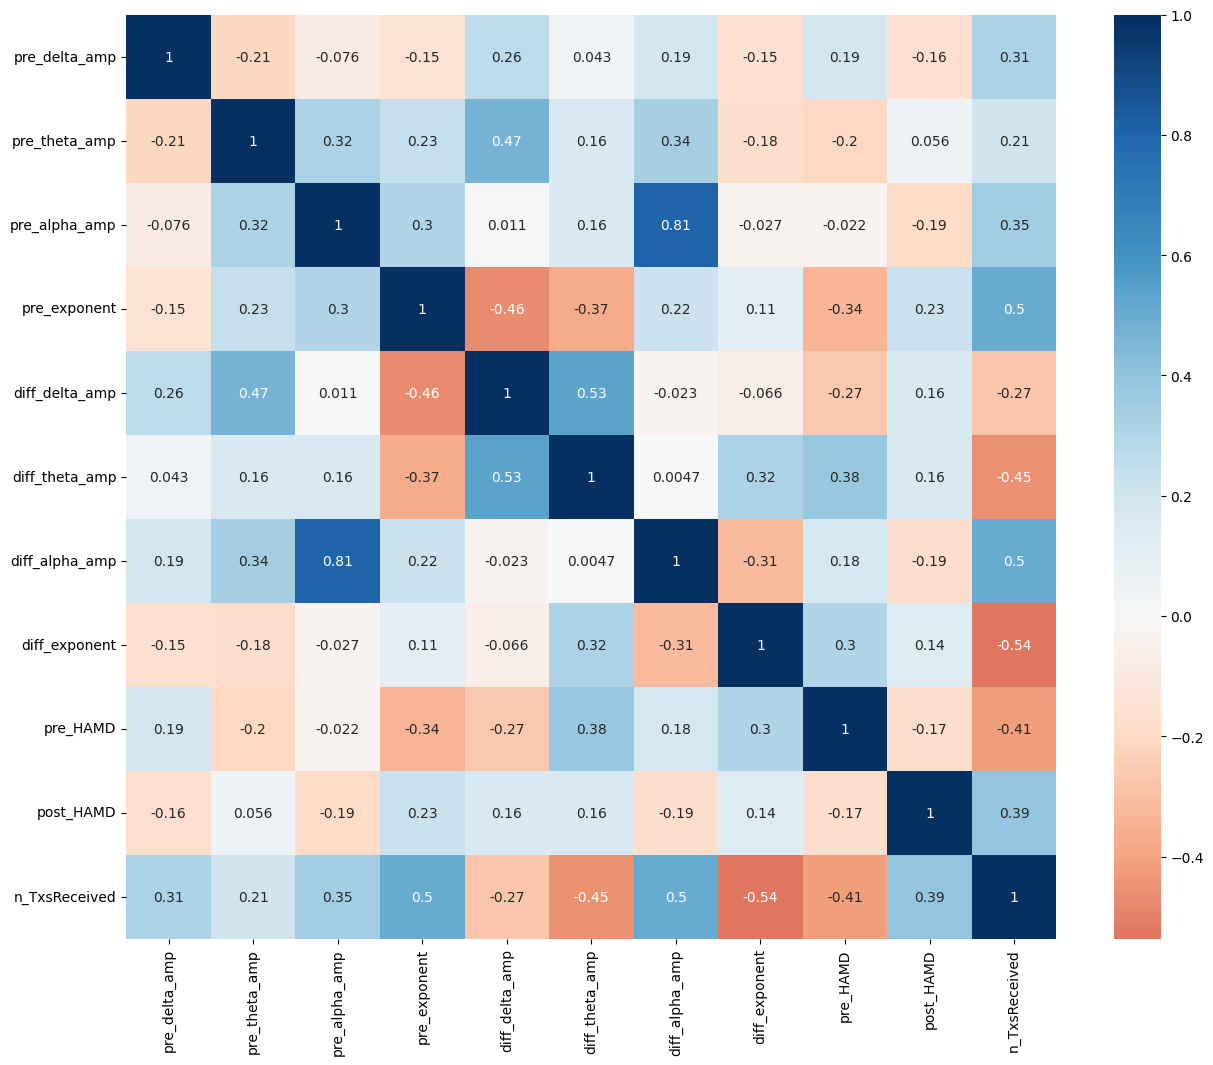

In [17]:
plt.figure(figsize=[15,12])
sns.heatmap(clin_eeg_df[features].corr(), cmap='RdBu', center=0, annot=True)

In [18]:
sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                k_features=3,
                                forward=False,
                                scoring='accuracy',
                                cv=None)
selected_features = sfs.fit(X=clin_eeg_df.iloc[:, clin_eeg_df.columns != 'post_HAMD'], y=clin_eeg_df['post_HAMD'])

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values